In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(42)

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the mapping of each letter

abc = 'abcdefghijklmnopqrstuvwxyz'
stoi = {s: i+1 for i, s in enumerate(abc)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [14]:
# build the databse
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# training, dev and test split
# 80%   10%   10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182383, 3]) torch.Size([182383])
torch.Size([22907, 3]) torch.Size([22907])
torch.Size([22856, 3]) torch.Size([22856])


In [6]:
# All the parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), requires_grad=True, generator=g)
W1 = torch.randn((30, 200), requires_grad=True, generator=g)
b1 = torch.randn(200, requires_grad=True, generator=g)
W2 = torch.randn((200, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]
print('We have', sum([p.nelement() for p in parameters]), 'number of parameters!')

We have 11897 number of parameters!


In [7]:
# Creating an array for Learning Rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [8]:
lrsi = []
lossi = []
stepi = []

In [9]:
# for lr in lrs:
for i in range(200_000):
    # Construct Minibatch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # Forward Pass
    emb = C[Xtr[ix]]
    h = (emb.view(-1, 30) @ W1 + b1).tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    stepi.append(i)
    # lrsi.append(lre[i])
    lossi.append(loss.log10().item())

print(loss.item())

1.981011152267456


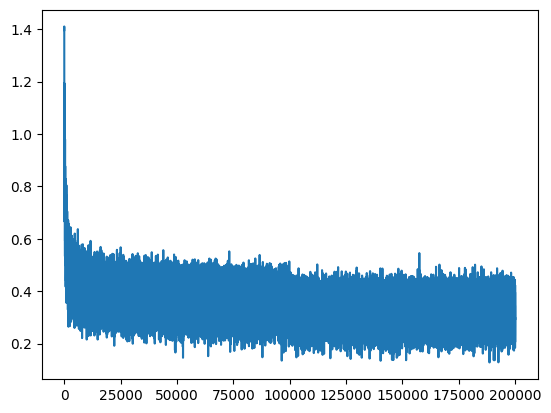

In [10]:
# use the graph to see good learning rates\
# plt.plot(lrsi, lossi)
plt.plot(stepi, lossi)


In [11]:
# Loss with training set
emb = C[Xtr]
h = (emb.view(-1, 30) @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1293, grad_fn=<NllLossBackward0>)

In [12]:
# Loss with dev set
emb = C[Xdev]
h = (emb.view(-1, 30) @ W1 + b1).tanh()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1758, grad_fn=<NllLossBackward0>)

In [15]:
# Sampling from the model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


aymidah.
roku.
macarianayya.
greeshey.
tahmanasafaite.
paasora.
rissa.
ara.
kaysani.
hriellonethiganson.
krin.
isrey.
paviana.
auhattie.
choy.
zavishal.
xaynovalon.
jaymonsaalo.
ruzahir.
bhait.


\# To visualize the C tensor when it was 2d\
plt.figure(figsize=(8, 8))\
plt.scatter(C\[:, 0].data, C\[:, 1].data, s=200)\
for i in range(C.shape\[0]):\
    plt.text(C\[i, 0].item(), C\[i, 1].item(), itos\[i], ha="center", va="center", color="white")\
plt.grid('minor')\